In [103]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u

In [104]:

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    # you can adapt this for your needs
    return np.log((arr[0] + 1e-10) / (arr[1] + 1e-10))


In [105]:
test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output/pp_output_test.h5'
#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'

In [106]:
test_f1 = h5py.File(test_path, 'r')
    

In [197]:
jet_flav = test_f1['jets']['HadronConeExclTruthLabelID']
is_tau = jet_flav == 5

In [198]:
x = test_f1['tracks']['tauTruthProng']
x = x[is_tau]

In [206]:
sig_1_prong = np.isin(x, 1)
sig_mask_1 = np.any(sig_1_prong, axis=1)
sig_3_prong = np.isin(x, 3)
sig_mask_3 = np.any(sig_3_prong, axis=1)

In [109]:
filtered = [test_f1['tracks']['rnn_fakeScore'],test_f1['tracks']['rnn_chargedScore'],test_f1['tracks']['rnn_conversionScore'],test_f1['tracks']['rnn_isolationScore'],test_f1['tracks']['valid'],test_f1['tracks']['NewTruthType']]

In [110]:
filtered = np.stack(filtered, axis=-1)

In [111]:
filtered_tau = filtered[is_tau]
track_scores = [filtered_tau[:,:,0], filtered_tau[:,:,1], filtered_tau[:,:,2], filtered_tau[:,:,3]]
track_valids = filtered_tau[:,:,4]
track_truth = filtered_tau[:,:,5]

In [57]:
# track_scores = [test_f1['tracks']['rnn_fakeScore'], test_f1['tracks']['rnn_chargedScore'], test_f1['tracks']['rnn_isolationScore'], test_f1['tracks']['rnn_conversionScore']]
# track_valids = test_f1['tracks']['valid']
# track_truth = test_f1['tracks']['NewTruthType']

In [112]:
track_valids = np.where(track_valids == 1, True, False)

In [113]:
valid_truth = track_truth[track_valids]
valid_truth[valid_truth == 6] = 0
valid_truth[valid_truth == 5] = 0
valid_truth[valid_truth == 4] = 0
valid_truth.shape


(8828073,)

In [114]:
rnn_scores = np.stack([track_scores[0], track_scores[1], track_scores[2], track_scores[3]], axis=-1)

In [115]:
f = np.argmax(rnn_scores[track_valids], axis=-1)

In [116]:
f = np.where(f != 0,f, 00) # 0 --> 00
f = np.where(f != 1,f, 10) # 1 --> 10
f = np.where(f != 2,f, 20) # 2 --> 20
f = np.where(f != 3,f, 30) # 3 --> 30

In [117]:
f = np.where(f == 00,3, f) # 00 --> 3
f = np.where(f == 10 ,0, f) # 10 --> 0
f = np.where(f == 20 ,1, f) # 20 --> 1
f = np.where(f == 30 ,2, f) # 30 --> 2

In [118]:
f

array([0, 1, 1, ..., 3, 3, 3])

In [119]:
valid_truth = np.where(valid_truth != 0,valid_truth, 00) # 0 --> 00
valid_truth = np.where(valid_truth != 1,valid_truth, 10) # 1 --> 10
valid_truth = np.where(valid_truth != 2,valid_truth, 20) # 2 --> 20
valid_truth = np.where(valid_truth != 3,valid_truth, 30) # 3 --> 30


In [120]:
valid_truth = np.where(valid_truth == 00,3, valid_truth) # 00 --> 3
valid_truth = np.where(valid_truth == 10 ,0, valid_truth) # 10 --> 0
valid_truth = np.where(valid_truth == 20 ,1, valid_truth) # 20 --> 1
valid_truth = np.where(valid_truth == 30 ,2, valid_truth) # 30 --> 2

Text(0.5, 1.0, 'inclusive (only tau)')

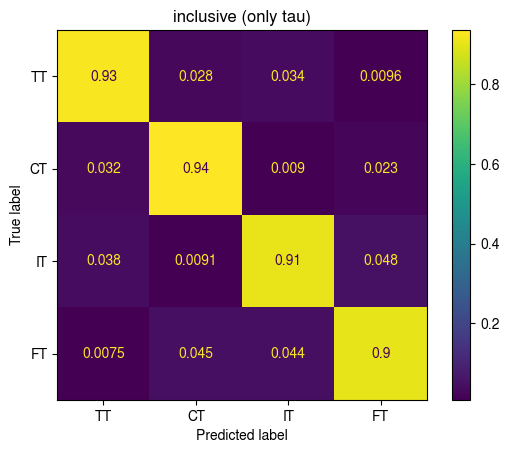

In [121]:
confusion_matrix = metrics.confusion_matrix(valid_truth, f, normalize='true')
#switched_conf_matrix = switch_axes(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (only tau)')

In [ ]:
# confusion_matrix = metrics.confusion_matrix(valid_truth, np.argmax(rnn_scores[track_valids], axis=-1), normalize='true')
# #switched_conf_matrix = switch_axes(confusion_matrix)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels=['FT', 'TT', 'CT', 'IT'])

# cm_display.plot()
# plt.title('inclusive')
# plt.show()

In [ ]:
# filtered3 = np.stack(filtered3, axis=-1)
# filtered_tau3 = filtered3[is_tau]
# track_scores3 = [filtered_tau3[:,:,0], filtered_tau3[:,:,1], filtered_tau3[:,:,2], filtered_tau3[:,:,3]]
# track_valids3 = filtered_tau3[:,:,4]
# track_truth3 = filtered_tau3[:,:,5]
# track_prong = filtered_tau3[:,:,6]

In [164]:
three_prong_jet_mask = [ np.sum(track_true_labels == 1) == 3  for track_true_labels in track_truth] 

In [165]:
np.sum(l == True for l in three_prong_jet_mask)

/tmp/ipykernel_89008/3278942670.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in three_prong_jet_mask)


144078

In [208]:
three_prong_jet_mask = np.array(three_prong_jet_mask)

In [209]:
# filtered_data = [test_f1['tracks']['rnn_fakeScore'],test_f1['tracks']['rnn_chargedScore'],test_f1['tracks']['rnn_conversionScore'],test_f1['tracks']['rnn_isolationScore'],test_f1['tracks']['valid'],test_f1['tracks']['NewTruthType']]

In [210]:
# filtered_data = np.stack(filtered_data, axis=-1)

In [211]:
three_prong_jet_mask.shape

(900000,)

In [188]:
(three_prong_jet_mask & sig_mask_3).shape

(900000,)

In [212]:
filtered_3_prongs = filtered_tau[three_prong_jet_mask & sig_mask_3]

In [190]:
filtered_3_prongs.shape

(144078, 30, 6)

In [214]:
track_scores3 = [filtered_3_prongs[:,:,0], filtered_3_prongs[:,:,1], filtered_3_prongs[:,:,2], filtered_3_prongs[:,:,3]]
track_valid3 = filtered_3_prongs[:,:,4]
track_truth3 = filtered_3_prongs[:,:,5]

In [215]:
#filtered_3_prongs = test_f1['tracks'][three_prong_jet_mask,:]

In [216]:
track_valid3 = np.where(track_valid3 == 1, True, False)

In [217]:
valid_truth3 = track_truth3[track_valid3]
valid_truth3[valid_truth3 == 6] = 0
valid_truth3[valid_truth3 == 5] = 0
valid_truth3[valid_truth3 == 4] = 0
valid_truth3.shape

(1503516,)

In [218]:
rnn_scores3 = np.stack([track_scores3[0], track_scores3[1], track_scores3[2], track_scores3[3]], axis=-1)

In [219]:
f3 = np.argmax(rnn_scores3[track_valid3], axis = -1)

In [220]:
f3 = np.where(f3 != 0,f3, 00) # 0 --> 00
f3 = np.where(f3 != 1,f3, 10) # 1 --> 10
f3 = np.where(f3 != 2,f3, 20) # 2 --> 20
f3 = np.where(f3 != 3,f3, 30) # 3 --> 30

In [221]:
f3 = np.where(f3 == 00,3, f3) # 00 --> 3
f3 = np.where(f3 == 10 ,0, f3) # 10 --> 0
f3 = np.where(f3 == 20 ,1, f3) # 20 --> 1
f3 = np.where(f3 == 30 ,2, f3) # 30 --> 2

In [222]:
valid_truth3 = np.where(valid_truth3 != 0,valid_truth3, 00) # 0 --> 00
valid_truth3 = np.where(valid_truth3 != 1,valid_truth3, 10) # 1 --> 10
valid_truth3 = np.where(valid_truth3 != 2,valid_truth3, 20) # 2 --> 20
valid_truth3 = np.where(valid_truth3 != 3,valid_truth3, 30) # 3 --> 30

In [223]:
valid_truth3 = np.where(valid_truth3 == 00,3, valid_truth3) # 00 --> 3
valid_truth3 = np.where(valid_truth3 == 10 ,0, valid_truth3) # 10 --> 0
valid_truth3 = np.where(valid_truth3 == 20 ,1, valid_truth3) # 20 --> 1
valid_truth3 = np.where(valid_truth3 == 30 ,2, valid_truth3) # 30 --> 2

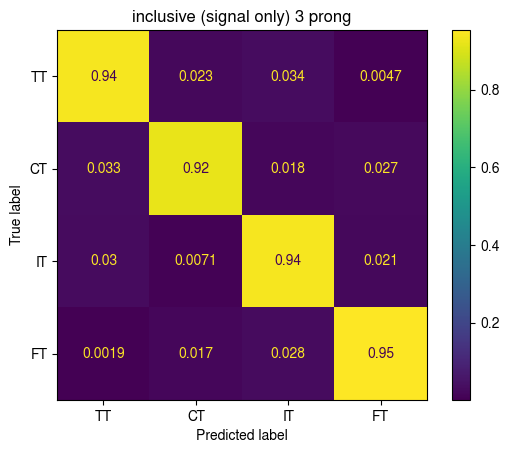

In [224]:
confusion_matrix = metrics.confusion_matrix(valid_truth3, f3, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) 3 prong')
plt.show()

In [97]:
sig_mask_1.shape

(1800000,)

In [225]:
one_prong_jet_mask = [np.sum(track_true_labels == 1) == 1  for track_true_labels in track_truth]

In [226]:
np.sum(l == True for l in one_prong_jet_mask)

/tmp/ipykernel_89008/3261831915.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(l == True for l in one_prong_jet_mask)


621646

In [227]:
one_prong_jet_mask = np.array(one_prong_jet_mask)

In [228]:
filtered_1_prongs = filtered_tau[one_prong_jet_mask & sig_mask_1]

In [229]:
track_scores1 = [filtered_1_prongs[:,:,0], filtered_1_prongs[:,:,1], filtered_1_prongs[:,:,2], filtered_1_prongs[:,:,3]]
track_valid1 = filtered_1_prongs[:,:,4]
track_truth1 = filtered_1_prongs[:,:,5]

In [230]:
track_valid1 = np.where(track_valid1 == 1, True, False)

In [231]:
valid_truth1 = track_truth1[track_valid1]
valid_truth1[valid_truth1 == 6] = 0
valid_truth1[valid_truth1 == 5] = 0
valid_truth1[valid_truth1 == 4] = 0
valid_truth1.shape

(5792918,)

In [232]:
rnn_scores1 = np.stack([track_scores1[0], track_scores1[1], track_scores1[2], track_scores1[3]], axis=-1)


In [233]:
f1 = np.argmax(rnn_scores1[track_valid1], axis = -1)

In [234]:
f1 = np.where(f1 != 0,f1, 00) # 0 --> 00
f1 = np.where(f1 != 1,f1, 10) # 1 --> 10
f1 = np.where(f1 != 2,f1, 20) # 2 --> 20
f1 = np.where(f1 != 3,f1, 30) # 3 --> 30


In [235]:
f1 = np.where(f1 == 00,3, f1) # 00 --> 3
f1 = np.where(f1 == 10 ,0, f1) # 10 --> 0
f1 = np.where(f1 == 20 ,1, f1) # 20 --> 1
f1 = np.where(f1 == 30 ,2, f1) # 30 --> 2

In [236]:

valid_truth1 = np.where(valid_truth1 != 0,valid_truth1, 00) # 0 --> 00
valid_truth1 = np.where(valid_truth1 != 1,valid_truth1, 10) # 1 --> 10
valid_truth1 = np.where(valid_truth1 != 2,valid_truth1, 20) # 2 --> 20
valid_truth1 = np.where(valid_truth1 != 3,valid_truth1, 30) # 3 --> 30


In [237]:
valid_truth1 = np.where(valid_truth1 == 00,3, valid_truth1) # 00 --> 3
valid_truth1 = np.where(valid_truth1 == 10 ,0, valid_truth1) # 10 --> 0
valid_truth1 = np.where(valid_truth1 == 20 ,1, valid_truth1) # 20 --> 1
valid_truth1 = np.where(valid_truth1 == 30 ,2, valid_truth1) # 30 --> 2

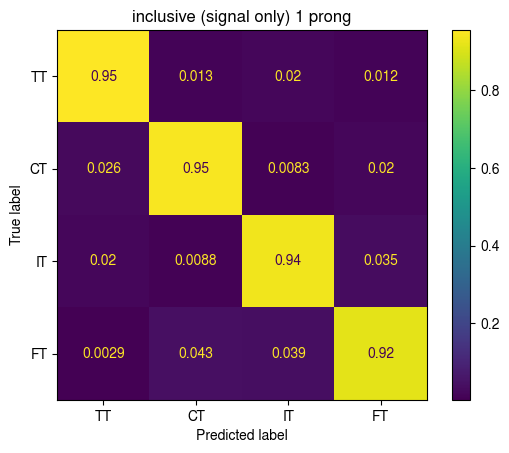

In [238]:
confusion_matrix = metrics.confusion_matrix(valid_truth1, f1, normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['TT', 'CT', 'IT', 'FT'])

cm_display.plot()
plt.title('inclusive (signal only) 1 prong')
plt.show()